## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [106]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [107]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

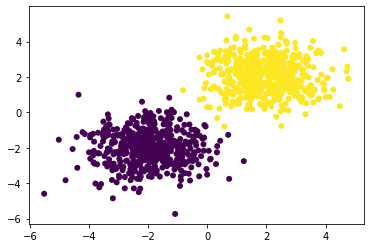

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

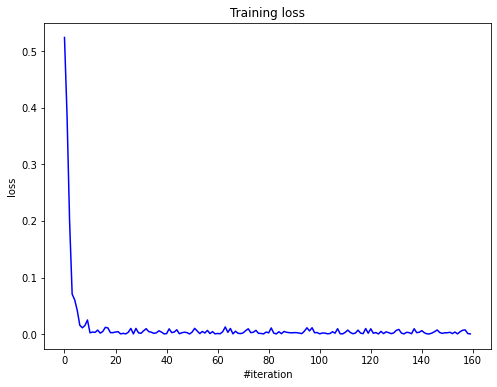

Current loss: 0.000320


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [96]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [97]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(y_train[:, None])
y_val_ohe = ohe.transform(y_val[:, None])
y_test_ohe = ohe.transform(y_test[:, None])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [157]:
from tqdm.auto import tqdm

In [185]:
def train_one_epoch(model, data, batch_size, 
                    criterion, optimizer=None, 
                    optimizer_config=None,
                    optimizer_state=None):
    train_loss = []
    for x_batch, y_batch in get_batches(data, batch_size):
        
        model.zeroGradParameters()
        
        # Forward
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
            
        # Backward
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)

        # Update weights
        optimizer(model.getParameters(), 
                  model.getGradParameters(), 
                  optimizer_config,
                  optimizer_state)      
            
        train_loss.append(loss)
        
    return np.mean(train_loss)


def validate(model, data, 
             batch_size, criterion):
    val_loss = []
    for x_batch, y_batch in get_batches(data, batch_size):
        
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)  
            
        val_loss.append(loss)
        
    return np.mean(val_loss)

In [186]:
def train(model, 
          train_data, 
          val_data, 
          n_epochs, 
          batch_size, 
          optimizer, 
          optimizer_config,
          optimizer_state,
          criterion, 
          title=''):
    
    train_losses = []
    val_losses = []
    
    for _ in tqdm(range(n_epochs), total=n_epochs, desc=title):
        # train one epoch
        model.train()
        train_loss = train_one_epoch(
            model, 
            train_data, 
            batch_size, 
            criterion,
            optimizer, 
            optimizer_config,
            optimizer_state
        )
        train_losses.append(train_loss)
            
        # validation
        model.evaluate()
        val_loss = validate(
            model, 
            val_data, 
            batch_size,
            criterion
        )
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [188]:
n_epochs = 30
batch_size = 128

In [193]:
# Training models without BatchNorm
activation_dict = {'ReLU' : ReLU, 
                   'ELU' : ELU, 
                   'LeakyReLU' : LeakyReLU, 
                   'SoftPlus' : SoftPlus}

losses_dict = {
    "train": {}, "val": {},
    "train_bn": {}, "val_bn": {}
}
for activation_name, activation in activation_dict.items():
    optimizer = sgd_momentum
    optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
    optimizer_state = {}

    criterion = ClassNLLCriterion()
    
    model = Sequential()
    model.add(Flatten())
    model.add(Linear(784, 50))
    model.add(activation())
    model.add(Linear(50, 10))
    model.add(LogSoftMax())
    
    train_loss, val_loss = train(
        model=model, 
        train_data=(X_train, y_train_ohe), 
        val_data=(X_val, y_val_ohe), 
        n_epochs=n_epochs, 
        batch_size=batch_size,
        optimizer=optimizer,
        optimizer_config=optimizer_config,
        optimizer_state=optimizer_state,
        criterion=criterion,
        title=activation_name
    )
    
    losses_dict["train"][activation_name] = train_loss
    losses_dict["val"][activation_name] = val_loss
    

ReLU:   0%|          | 0/30 [00:00<?, ?it/s]

ELU:   0%|          | 0/30 [00:00<?, ?it/s]

LeakyReLU:   0%|          | 0/30 [00:00<?, ?it/s]

SoftPlus:   0%|          | 0/30 [00:00<?, ?it/s]

In [194]:
# Training models with BatchNorm
for activation_name, activation in activation_dict.items():
    optimizer = sgd_momentum
    optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
    optimizer_state = {}

    criterion = ClassNLLCriterion()
    
    model = Sequential()
    model.add(Flatten())
    model.add(Linear(784, 50))
    model.add(BatchNormalization(alpha=0.9))
    model.add(ChannelwiseScaling(50))
    model.add(activation())
    model.add(Linear(50, 10))
    model.add(LogSoftMax())
    
    train_loss, val_loss = train(
        model=model, 
        train_data=(X_train, y_train_ohe), 
        val_data=(X_val, y_val_ohe), 
        n_epochs=n_epochs, 
        batch_size=batch_size,
        optimizer=optimizer,
        optimizer_config=optimizer_config,
        optimizer_state=optimizer_state,
        criterion=criterion,
        title=activation_name + "_BatchNorm"
    )
    
    losses_dict["train_bn"][activation_name] = train_loss
    losses_dict["val_bn"][activation_name] = val_loss
    

ReLU_BatchNorm:   0%|          | 0/30 [00:00<?, ?it/s]

ELU_BatchNorm:   0%|          | 0/30 [00:00<?, ?it/s]

LeakyReLU_BatchNorm:   0%|          | 0/30 [00:00<?, ?it/s]

SoftPlus_BatchNorm:   0%|          | 0/30 [00:00<?, ?it/s]

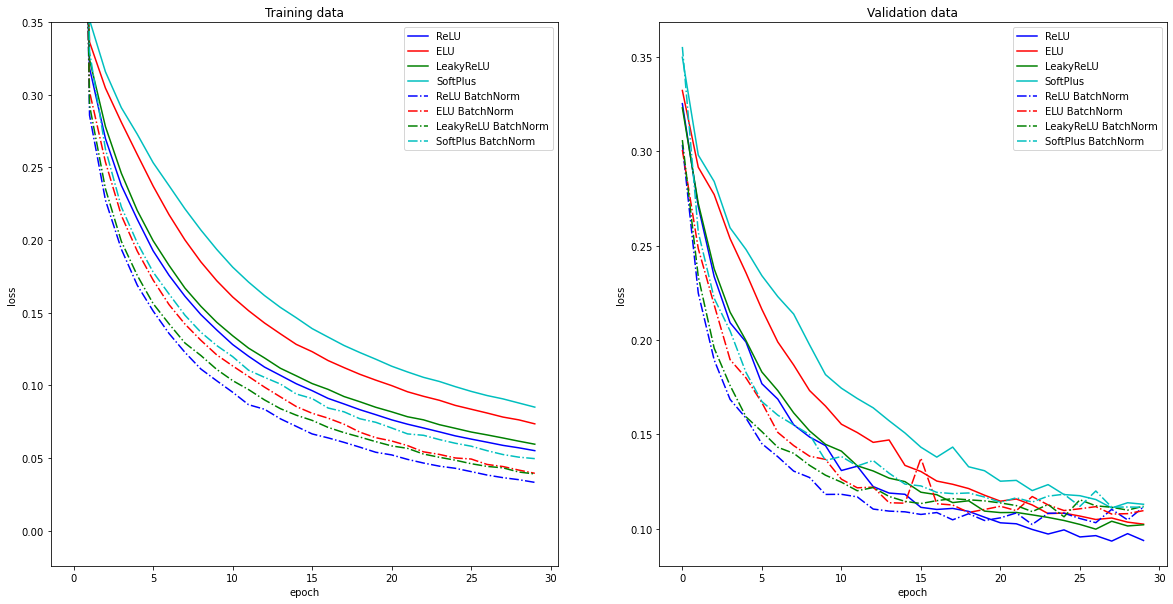

In [195]:
plt.figure(figsize=(20, 10))
colours = ['b', 'r', 'g', 'c']

plt.subplot(1, 2, 1)
plt.title("Training data")
for i, (activation_name, losses) in enumerate(losses_dict["train"].items()):
    plt.plot(losses, colours[i], label=activation_name)
for i, (activation_name, losses) in enumerate(losses_dict["train_bn"].items()):
    plt.plot(losses, colours[i] + "-.", label=activation_name + " BatchNorm")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(top=0.35)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Validation data")
for i, (activation_name, losses) in enumerate(losses_dict["val"].items()):
    plt.plot(losses, colours[i], label=activation_name)
for i, (activation_name, losses) in enumerate(losses_dict["val_bn"].items()):
    plt.plot(losses, colours[i] + "-.", label=activation_name + " BatchNorm")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

Для большей наглядности нарисую график для каждой функции активации отдельно

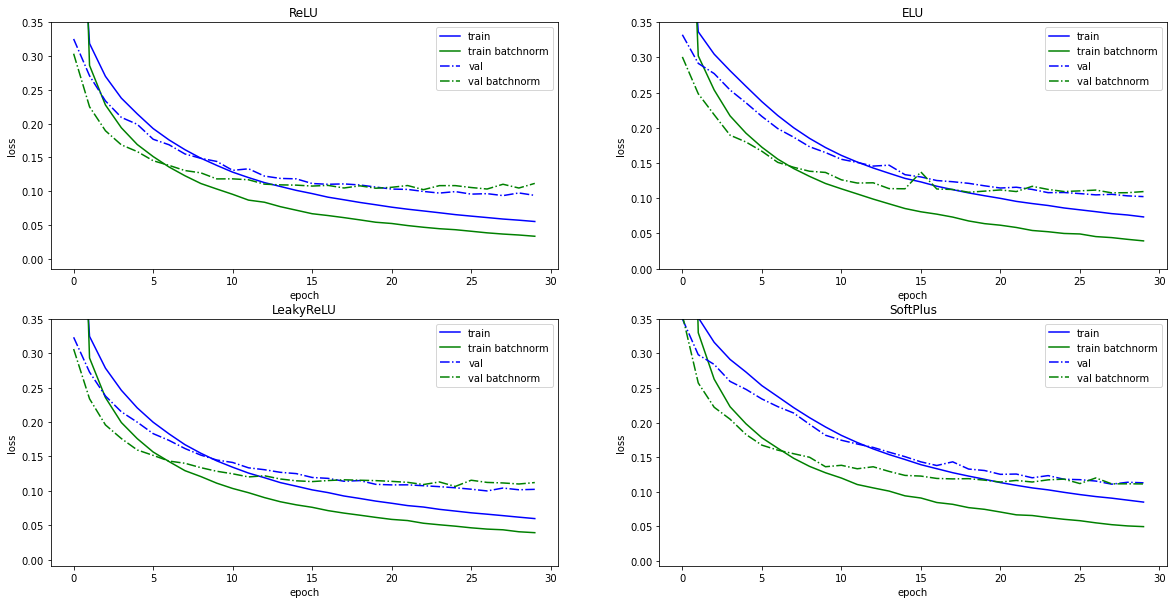

In [196]:
plt.figure(figsize=(20, 10))

for i, activation_name in enumerate(activation_dict.keys()): 
    plt.subplot(2, 2, i + 1)
    plt.title(activation_name)
    plt.plot(losses_dict["train"][activation_name], 'b', label="train")
    plt.plot(losses_dict["train_bn"][activation_name], 'g', label="train batchnorm")
    plt.plot(losses_dict["val"][activation_name], 'b-.', label="val")
    plt.plot(losses_dict["val_bn"][activation_name], 'g-.', label="val batchnorm")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(top=0.35)
    plt.legend()

plt.show()

In [205]:
optimizers_dict = {
    "sgd_momentum": (
        sgd_momentum, 
        {
            "config": {
                "learning_rate": 1e-3, 
                "momentum": 0.9,
            },
            "state": {},
        }
    ), 
    "adam": (
        adam_optimizer, 
        {
            "config": {
                "learning_rate": 1e-3, 
                "beta1": 0.9,
                "beta2": 0.999,
                "epsilon": 1e-8,
            },
            "state": {},
        }
    ), 
}

opt_losses_dict = {
    "train": {}, "val": {},
}
learning_rates = [1e-2, 1e-3]
for optimizer_name, (optimizer, conf) in optimizers_dict.items():
    for learning_rate in learning_rates:
        opt_name = optimizer_name + f"(lr={learning_rate})"
        optimizer_config = conf['config']
        optimizer_config['learning_rate'] = learning_rate
        optimizer_state = conf['state']

        criterion = ClassNLLCriterion()

        model = Sequential()
        model.add(Flatten())
        model.add(Linear(784, 50))
        model.add(activation())
        model.add(Linear(50, 10))
        model.add(LogSoftMax())

        train_loss, val_loss = train(
            model=model, 
            train_data=(X_train, y_train_ohe), 
            val_data=(X_val, y_val_ohe), 
            n_epochs=n_epochs, 
            batch_size=batch_size,
            optimizer=optimizer,
            optimizer_config=optimizer_config,
            optimizer_state=optimizer_state,
            criterion=criterion,
            title=opt_name
        )

        opt_losses_dict["train"][opt_name] = train_loss
        opt_losses_dict["val"][opt_name] = val_loss
    

sgd_momentum(lr=0.01):   0%|          | 0/30 [00:00<?, ?it/s]

sgd_momentum(lr=0.001):   0%|          | 0/30 [00:00<?, ?it/s]

adam(lr=0.01):   0%|          | 0/30 [00:00<?, ?it/s]

adam(lr=0.001):   0%|          | 0/30 [00:00<?, ?it/s]

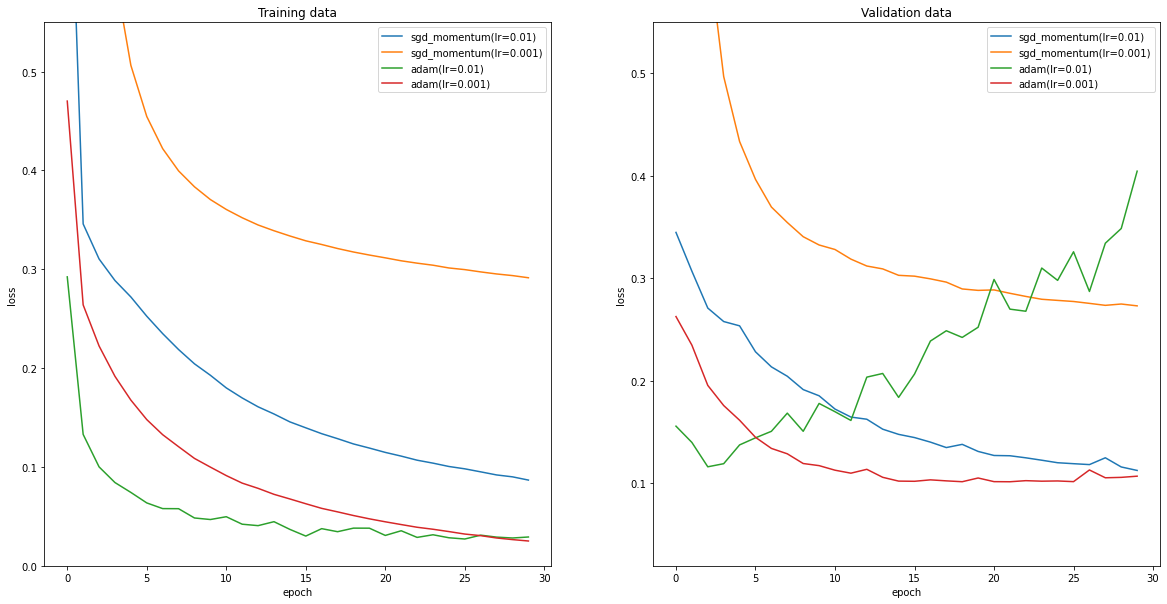

In [210]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Training data")
for i, (optimizer_name, losses) in enumerate(opt_losses_dict["train"].items()):
    plt.plot(losses, label=optimizer_name)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(bottom=0.0, top=0.55)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Validation data")
for i, (optimizer_name, losses) in enumerate(opt_losses_dict["val"].items()):
    plt.plot(losses, label=optimizer_name)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(top=0.55)
plt.legend()

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

Сравнение функций активации:  

Лучше всего себя показывает `ReLU`, тогда как используя `SoftPlus` модель сходится хуже. При использовании `BatchNormalization` одна эпоха в среднем обучается дольше, но сходимость на трейне и валидации улучшается. Однако, когда loss перестает сильно убывать, можно заметить, что ошибка с использованием `BatchNormalization` становится больше, чем без, хотя эта разница не столь значима.   


Сревнение `SGD` и `ADAM`:   

Результаты, полученные при использовании `sgm_momentum` и `adam_optimizer` очень сильно зависят от learning_rate и требуют разного числа эпох для обучения, так как `Adam` сходится намного быстрее. На графиках можно заметить, что при lr=1e-2 `Adam` сходится за 3 эпохи, после чего loss на валидации начинает расти, тогда как `SGD` продолжает убывать. При уменьшении lr до 1e-3 `Adam` сходится более плавно и уже не наблюдается явного переобучения, но `SGD` с данным learning rate сходится слишком долго. В целом можно сделать вывод, что `Adam` хорошо работает из под "коробки" и не требует тщательной настройки. `SGD` тоже является отличным вариантом, но надо начинать обучать с большим learning rate и постепенно уменьшать его по мере обучения модели.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [213]:
# Your code goes here. ################################################

optimizer = adam_optimizer
optimizer_config = {
    "learning_rate": 1e-2, 
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
}
optimizer_state = {}
n_epochs = 5

criterion = ClassNLLCriterion()

model = Sequential()
model.add(Flatten())
model.add(Linear(784, 784 * 2))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(784 * 2))
model.add(ReLU())
model.add(Linear(784 * 2, 784))
model.add(Dropout())
model.add(ReLU())
model.add(Linear(784, 784 // 2))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(784 // 2))
model.add(ReLU())
model.add(Linear(784 // 2, 10))
model.add(LogSoftMax())

train_loss, val_loss = train(
    model, 
    train_data=(X_train, y_train_ohe), 
    val_data=(X_val, y_val_ohe), 
    n_epochs=n_epochs, 
    batch_size=batch_size,
    optimizer=optimizer,
    optimizer_config=optimizer_config,
    optimizer_state=optimizer_state,
    criterion=criterion
)
    

  0%|          | 0/5 [00:00<?, ?it/s]

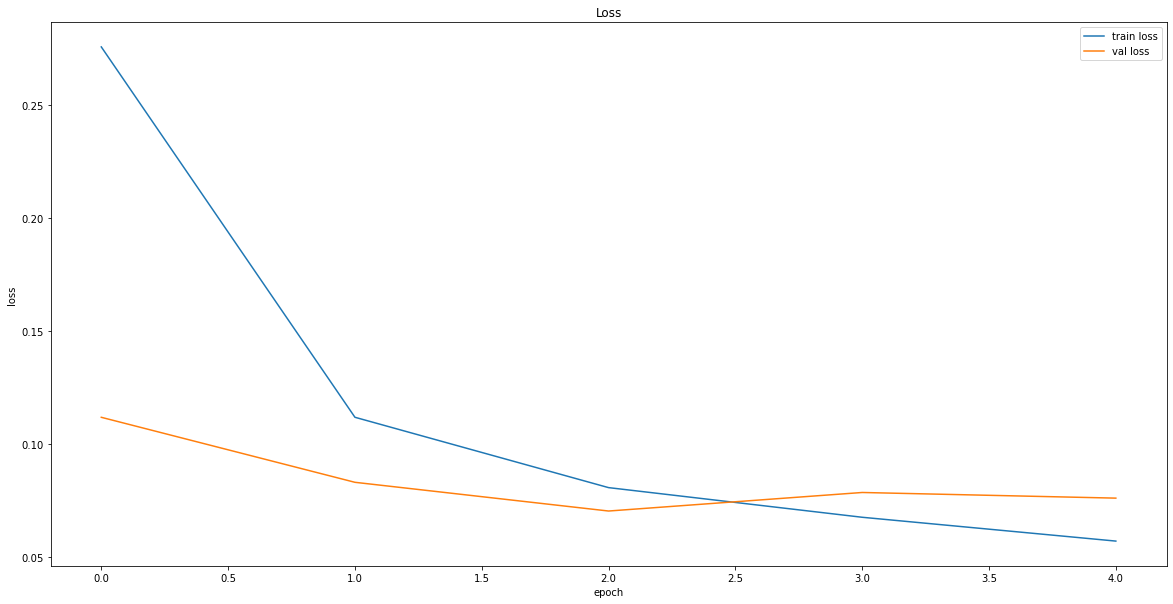

In [214]:
plt.figure(figsize=(20, 10))

plt.title("Loss")
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

In [232]:
predictions = []
true_labels = []
for x_batch, y_batch in tqdm(get_batches((X_test, y_test_ohe), batch_size), desc="predicting..."):
        
    predictions.extend(np.argmax(model.forward(x_batch), axis=1))
    true_labels.extend(np.argmax(y_batch, axis=1))

predicting...: 0it [00:00, ?it/s]

Print here your accuracy on test set. It should be around 90%.

In [233]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score


print(accuracy_score(true_labels, predictions))

0.9779


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [242]:
# Your beautiful code here.
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [293]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx].reshape(-1)).float()
        y = torch.tensor(self.y[idx]).long()
        return X, y

train_data = MyDataset(X_train, y_train)
val_data = MyDataset(X_val, y_val)
test_data = MyDataset(X_test, y_test)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [294]:
model = nn.Sequential(
    nn.Linear(784, 784 * 2),
    nn.BatchNorm1d(784 * 2),
    nn.ReLU(),
    nn.Linear(784 * 2, 784),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(784, 784 // 2),
    nn.BatchNorm1d(784 // 2),
    nn.ReLU(),
    nn.Linear(784 // 2, 10),
    nn.LogSoftmax()
)

In [299]:
def torch_train_one_epoch(model, dataloader, criterion, optimizer):
    train_loss = 0.
    for x_batch, y_batch in tqdm(dataloader, total=len(dataloader), desc="training epoch...", leave=False):
        
        optimizer.zero_grad()
        
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        
        loss.backward()      
        
        train_loss += loss.item()

        optimizer.step()
        
    return train_loss / len(dataloader)


def torch_validate(model, dataloader, criterion):
    val_loss = 0.
    for x_batch, y_batch in tqdm(dataloader, total=len(dataloader), desc="validate...", leave=False):
        
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)  
            
        val_loss += loss.item()
        
    return val_loss / len(dataloader)


def torch_train(model, train_dl, val_dl, 
                n_epochs, optimizer, criterion):
    
    train_losses = []
    val_losses = []
    
    for _ in tqdm(range(n_epochs), total=n_epochs, desc="Training..."):
        # train one epoch
        model.train()
        train_loss = torch_train_one_epoch(
            model, 
            train_dl, 
            criterion,
            optimizer, 
        )
        train_losses.append(train_loss)
            
        # validation
        model.eval()
        val_loss = torch_validate(
            model, 
            val_dl, 
            criterion
        )
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [300]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 5

criterion = nn.NLLLoss()

train_loss, val_loss = torch_train(
    model, 
    train_dl=train_dl, 
    val_dl=val_dl, 
    n_epochs=n_epochs, 
    optimizer=optimizer,
    criterion=criterion
)

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

training epoch...:   0%|          | 0/390 [00:00<?, ?it/s]

validate...:   0%|          | 0/79 [00:00<?, ?it/s]

training epoch...:   0%|          | 0/390 [00:00<?, ?it/s]

validate...:   0%|          | 0/79 [00:00<?, ?it/s]

training epoch...:   0%|          | 0/390 [00:00<?, ?it/s]

validate...:   0%|          | 0/79 [00:00<?, ?it/s]

training epoch...:   0%|          | 0/390 [00:00<?, ?it/s]

validate...:   0%|          | 0/79 [00:00<?, ?it/s]

training epoch...:   0%|          | 0/390 [00:00<?, ?it/s]

validate...:   0%|          | 0/79 [00:00<?, ?it/s]

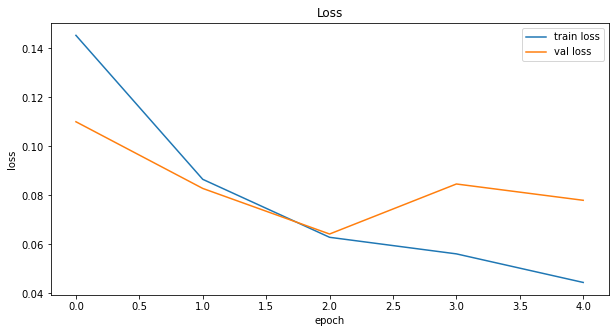

In [307]:
plt.figure(figsize=(10, 5))

plt.title("Loss")
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

In [304]:
predictions = []
true_labels = []
for x_batch, y_batch in tqdm(test_dl, total=len(test_dl), desc="predicting..."):
        
    predictions.extend(np.argmax(model(x_batch).detach().numpy(), axis=1))
    true_labels.extend(y_batch)

predicting...:   0%|          | 0/79 [00:00<?, ?it/s]

In [305]:
print(accuracy_score(true_labels, predictions))

0.9784
